Поколение 1, лучшая длина маршрута: 24283.40
Поколение 2, лучшая длина маршрута: 24283.40
Поколение 3, лучшая длина маршрута: 23448.24
Поколение 4, лучшая длина маршрута: 23118.67
Поколение 5, лучшая длина маршрута: 23118.67
Поколение 6, лучшая длина маршрута: 22979.32
Поколение 7, лучшая длина маршрута: 22168.90
Поколение 8, лучшая длина маршрута: 21690.33
Поколение 9, лучшая длина маршрута: 21602.40
Поколение 10, лучшая длина маршрута: 21602.40
Поколение 11, лучшая длина маршрута: 20997.86
Поколение 12, лучшая длина маршрута: 20997.86
Поколение 13, лучшая длина маршрута: 20997.86
Поколение 14, лучшая длина маршрута: 20484.28
Поколение 15, лучшая длина маршрута: 20484.28
Поколение 16, лучшая длина маршрута: 20484.28
Поколение 17, лучшая длина маршрута: 20484.28
Поколение 18, лучшая длина маршрута: 19610.58
Поколение 19, лучшая длина маршрута: 19393.08
Поколение 20, лучшая длина маршрута: 19393.08
Поколение 21, лучшая длина маршрута: 18595.07
Поколение 22, лучшая длина маршрута: 18595.

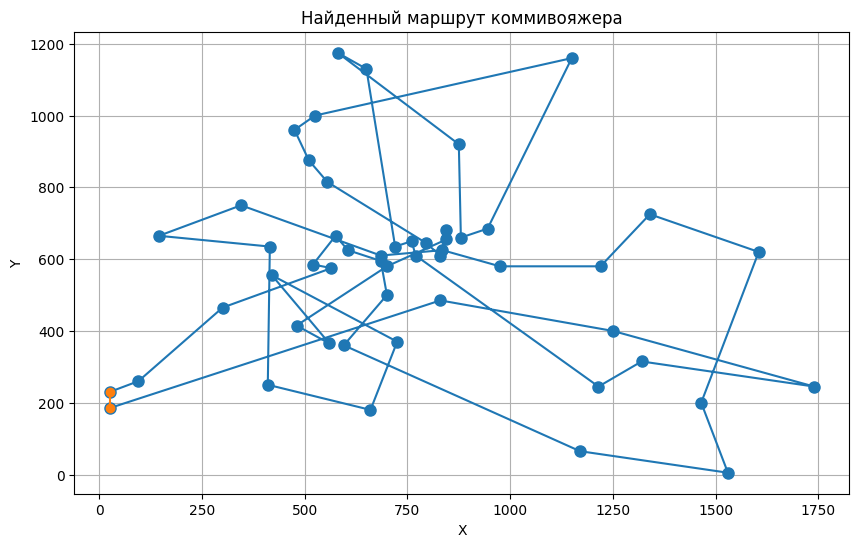

Сравнение маршрутов:
Общая длина лучшего маршрута: 11019.73
Общая длина найденного маршрута: 12086.14


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from deap import base, creator, tools, algorithms 
import math 
import time 
import sys 
 
# Параметры 
FILENAME = "D:/GIT/VuzUC/7SEM/EMPPIS/LAB3/berlin52.txt"  # Имя файла с координатами городов 
POPULATION_SIZE = 500       # Размер популяции 
N_GENERATIONS = 1000         # Максимальное количество поколений 
CX_PROB = 0.9                # Вероятность кроссовера 
MUT_PROB = 0.1               # Вероятность мутации 
TOURNAMENT_SIZE = 5          # Размер турнира 
MUTATION_INDPB = 0.2         # Вероятность мутации каждого гена 
ELITE_SIZE = 1               # Количество лучших решений, сохраняемых между поколениями 
PATIENCE = 100               # Порог терпения (макс. кол-во поколений без улучшений) 
 
# Чтение координат городов из файла 
def read_cities(filename): 
    cities = [] 
    try: 
        with open(filename, 'r') as f: 
            for line in f: 
                parts = line.strip().split() 
                if len(parts) == 3:  # Ожидаем: номер, x, y 
                    cities.append((float(parts[1]), float(parts[2]))) 
    except FileNotFoundError: 
        print(f"Файл '{filename}' не найден.")
        sys.exit(1) 
    except Exception as e: 
        print(f"Ошибка при чтении файла: {e}") 
        sys.exit(1) 
    return np.array(cities)
# Функция для вычисления евклидова расстояния между двумя городами 
def euclidean_distance(city1, city2): 
    return math.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2) 
 
# Функция для вычисления общей длины маршрута 
def total_distance(route, cities): 
    dist = 0 
    for i in range(len(route) - 1): 
        dist += euclidean_distance(cities[route[i]], cities[route[i - 1]]) 
    dist += euclidean_distance(cities[route[-1]], cities[route[0]])  # Замыкание тура 
    return dist 
 
# Настройка DEAP: создание индивидуумов и популяции 
def setup_ga(cities): 
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Минимизация расстояния 
    creator.create("Individual", list, fitness=creator.FitnessMin) 
 
    toolbox = base.Toolbox() 
    toolbox.register("indices", np.random.permutation, len(cities)) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices) 
    toolbox.register("population", tools.initRepeat, list, toolbox.individual) 
 
    toolbox.register("mate", tools.cxPartialyMatched)  # PMX-кроссовер 
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=MUTATION_INDPB)  # Мутация 
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE) 
    toolbox.register("evaluate", lambda ind: (total_distance(ind, cities),)) 
 
    return toolbox 
 
# Алгоритм с проверкой на отсутствие улучшений 
def run_ga(toolbox): 
    pop = toolbox.population(n=POPULATION_SIZE) 
    hof = tools.HallOfFame(ELITE_SIZE) 
    stats = tools.Statistics(lambda ind: ind.fitness.values[0]) 
    stats.register("min", np.min) 
    stats.register("avg", np.mean) 
 
    start_time = time.time() 
 
    # Инициализация переменных для отслеживания улучшений 
    best_fitness = float("inf") 
    generations_without_improvement = 0 
 
    for gen in range(N_GENERATIONS): 
        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB, 
                                           ngen=1, stats=stats, halloffame=hof, verbose=False) 
 
        current_best = hof[0].fitness.values[0] 
        print(f"Поколение {gen + 1}, лучшая длина маршрута: {current_best:.2f}") 
 
        if current_best < best_fitness: 
            best_fitness = current_best 
            generations_without_improvement = 0  # Сбросить счётчик 
        else: 
            generations_without_improvement += 1 
 
        # Если нет улучшений в течение PATIENCE поколений, остановить алгоритм 
        if generations_without_improvement >= PATIENCE: 
            print(f"Остановка на {gen + 1} поколении из-за отсутствия улучшений.") 
            break 
 
    end_time = time.time() 
    print(f"Время выполнения: {end_time - start_time:.2f} секунд") 
 
    return hof[0] 
 
# Функция для визуализации маршрута 
def plot_route(route, cities): 
    route_cities = cities[route] 
    plt.figure(figsize=(10, 6)) 
    plt.plot(route_cities[:, 0], route_cities[:, 1], 'o-', markersize=8) 
    plt.plot([route_cities[-1, 0], route_cities[0, 0]],  
             [route_cities[-1, 1], route_cities[0, 1]], 'o-')  # Замыкание маршрута 
    plt.title("Найденный маршрут коммивояжера") 
    plt.xlabel("X") 
    plt.ylabel("Y") 
    plt.grid(True) 
    plt.show() 
 
# Функция для сравнения найденного маршрута с лучшим маршрутом 
def compare_routes(optimal_route, found_route, cities): 
    # Вычисление общей длины маршрутов 
    best_distance = total_distance(optimal_route, cities) 
    found_distance = total_distance(found_route, cities) 
 
    print("Сравнение маршрутов:") 
    print(f"Общая длина лучшего маршрута: {best_distance:.2f}") 
    print(f"Общая длина найденного маршрута: {found_distance:.2f}") 

    # Основная функция 
def main(): 
    cities = read_cities(FILENAME) 
    toolbox = setup_ga(cities) 
    best_route = run_ga(toolbox) 
    # Ваш лучший маршрут, который нужно сравнить (вставьте свои значения, начиная с 0) 
    optimal_route = [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 
    24, 3, 5, 14, 4, 23, 47, 35, 34, 37, 36, 33, 30, 29, 41, 43, 15, 28, 49, 1, 2, 19, 20, 21, 22, 38, 39, 
    8] 


    print(f"Лучший найденный маршрут: {best_route}") 
    print(f"Общая длина маршрута: {total_distance(best_route, cities):.2f}") 
    plot_route(best_route, cities) 
    # Сравнение маршрутов 
    compare_routes(optimal_route, best_route, cities) 
if __name__ == "__main__": 
    main()